# Implement a Neural Network - Binary Classification

Lets implement a basic neural network in python for binary classification which is used to classify if a given image is 0 or 1.

In [5]:
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import  metrics

## 2.1 Dataset Preparation
First step is to load and prepare the dataset

In [6]:
train = pd.read_csv("train.csv")

d:\python机器学习\其他\.venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

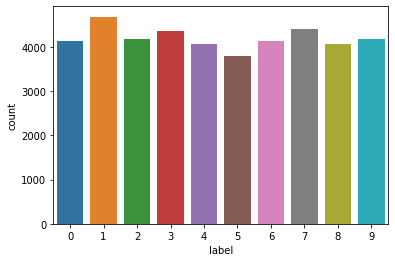

In [7]:
# sns.countplot(train['label'])

###我们也可以使用直方图来画
# plt.hist(train['label'],10)
# plt.show()

# fig,ax = plt.subplots()
# n,bins,patches = ax.hist(train['label'],10,edgecolor='w')

sns.countplot(train['label'])

#ax是基于坐标轴来处理数据的，所以有x、y相关的设置属性

In [8]:
# Check for null and missing values
train.isnull() # 判断整个矩阵的每个单元格的是否null，若是则返回True
train.isnull().any(axis=1).describe()
# isnull用来判断每个元素是否nan，none，nat类型，若是，则判断为true，any类似于或操作

count     42000
unique        1
top       False
freq      42000
dtype: object

I check for corrupted images (missing values inside).

There is no missing values in the train and test dataset. So we can safely go ahead.

In [9]:
# include only the rows having label = 0 or 1 (binary classification)
# 本次训练只训练 分类为0或者1的
X = train[train['label'].isin([0, 1])]

# target variable
Y = train[train['label'].isin([0, 1])]['label']

# remove the label from X
X = X.drop(['label'], axis = 1) #drop删除指定的数据，axi=1代表按照列删除,若是没有指定，则需要输入行索引，按照行来删除

## 2.2 Implementing a Activation Function
We will use sigmoid activation function because it outputs the values between 0 and 1 so its a good choice for a binary classification problem

In [10]:
# implementing a sigmoid activation function
def sigmoid(z):
    s = 1.0/ (1 + np.exp(-z))    
    return s

## 2.3 Define Neural Network Architecture
Create a model with three layers - Input, Hidden, Output.

In [84]:
def network_architecture(X, Y):
    # nodes in input layer
    n_x = X.shape[0] 
    # nodes in hidden layer
    n_h = 10          
    # nodes in output layer
    n_y = Y.shape[0] 
    return (n_x, n_h, n_y)

## 2.4 Define Neural Network Parameters
Neural Network parameters are weights and bias which we need to initialze with zero values. The first layer only contains inputs so there are no weights and bias, but the hidden layer and the output layer have a weight and bias term. (W1, b1 and W2, b2)

In [85]:
def define_network_parameters(n_x, n_h, n_y):
    W1 = np.random.randn(n_h,n_x) * 0.01 # random initialization
    b1 = np.zeros((n_h, 1)) # zero initialization
    W2 = np.random.randn(n_y,n_h) * 0.01 
    b2 = np.zeros((n_y, 1)) 
    return {"W1": W1, "b1": b1, "W2": W2, "b2": b2}  

## 2.5 Implement Forward Propagation
The hidden layer and output layer will compute the activations using sigmoid activation function and will pass it in the forward direction. While computing this activation, the input is multiplied with weight and added with bias before passing it to the function.

In [86]:
def forward_propagation(X, params):
    Z1 = np.dot(params['W1'], X)+params['b1'] #第一个参数有n_h*n_x,第二个参数有n_x*1,第三个参数有n_h*1 结果z应该是n_h*1
    A1 = sigmoid(Z1)

    Z2 = np.dot(params['W2'], A1)+params['b2']
    A2 = sigmoid(Z2)
    return {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2}

## 2.6 Compute the Network Error
To compute the cost, one straight forward approach is to compute the absolute error among prediction and actual value. But a better loss function is the log loss function which is defines as :

-Summ ( Log (Pred) Actual + Log (1 - Pred ) Actual ) / m

In [87]:
def compute_error(Predicted, Actual):
    logprobs = np.multiply(np.log(Predicted), Actual)+ np.multiply(np.log(1-Predicted), 1-Actual)
    cost = -np.sum(logprobs) / Actual.shape[1] 
    return np.squeeze(cost)

## 2.7 Implement Backward Propagation
In backward propagation function, the error is passed backward to previous layers and the derivatives of weights and bias are computed. The weights and bias are then updated using the derivatives.

In [88]:
def backward_propagation(params, activations, X, Y):
    m = X.shape[1]
    
    # output layer
    dZ2 = activations['A2'] - Y # compute the error derivative 
    dW2 = np.dot(dZ2, activations['A1'].T) / m # compute the weight derivative 
    db2 = np.sum(dZ2, axis=1, keepdims=True)/m # compute the bias derivative
    
    # hidden layer
    dZ1 = np.dot(params['W2'].T, dZ2)*(1-np.power(activations['A1'], 2))
    dW1 = np.dot(dZ1, X.T)/m
    db1 = np.sum(dZ1, axis=1,keepdims=True)/m
    
    return {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}

def update_parameters(params, derivatives, alpha = 1.2):
    # alpha is the model's learning rate 
    
    params['W1'] = params['W1'] - alpha * derivatives['dW1']
    params['b1'] = params['b1'] - alpha * derivatives['db1']
    params['W2'] = params['W2'] - alpha * derivatives['dW2']
    params['b2'] = params['b2'] - alpha * derivatives['db2']
    return params

## 2.8 Compile and Train the Model
Create a function which compiles all the key functions and creates a neural network model.

In [89]:
def neural_network(X, Y, n_h, num_iterations=100):
    n_x = network_architecture(X, Y)[0]
    n_y = network_architecture(X, Y)[2]
    
    params = define_network_parameters(n_x, n_h, n_y)
    for i in range(0, num_iterations):
        results = forward_propagation(X, params)
        error = compute_error(results['A2'], Y)
        derivatives = backward_propagation(params, results, X, Y) 
        params = update_parameters(params, derivatives)    
    return params

In [90]:
y = Y.values.reshape(1, Y.size)
x = X.T.values
model = neural_network(x, y, n_h = 10, num_iterations = 10)

C:\Users\Jaon\AppData\Local\Temp/ipykernel_18372/603398955.py:3: RuntimeWarning: overflow encountered in exp
  s = 1.0/ (1 + np.exp(-z))
C:\Users\Jaon\AppData\Local\Temp/ipykernel_18372/141761193.py:2: RuntimeWarning: divide by zero encountered in log
  logprobs = np.multiply(np.log(Predicted), Actual)+ np.multiply(np.log(1-Predicted), 1-Actual)
C:\Users\Jaon\AppData\Local\Temp/ipykernel_18372/141761193.py:2: RuntimeWarning: invalid value encountered in multiply
  logprobs = np.multiply(np.log(Predicted), Actual)+ np.multiply(np.log(1-Predicted), 1-Actual)
d:\python机器学习\其他\.venv\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


## 2.9 Predictions

In [91]:
def predict(parameters, X):
    results = forward_propagation(X, parameters)
    print (results['A2'][0])
    predictions = np.around(results['A2'])    
    return predictions

predictions = predict(model, x)
print ('Accuracy: %d' % float((np.dot(y,predictions.T) + np.dot(1-y,1-predictions.T))/float(y.size)*100) + '%')

[1. 1. 1. ... 1. 1. 1.]
Accuracy: 444%


## Confusion matrix
Confusion matrix can be very helpfull to see your model drawbacks.

In [107]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    ## 设定图片有多少行，多少列，用于后面向每个格子中填充数据
    plt.imshow(cm,cmap=cmap) ##四舍五入 interpolation='nearest'

    #设置标题，以及颜色条
    plt.title(title)
    plt.colorbar()
    
    #分为设置x方向和y方向有多少个分类，以及每个分类显示的名称
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    #判断是否需要归一化
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [109]:
confusion_mtx = confusion_matrix(predictions.reshape(-1,1), y.reshape(-1,1)) ##行向量转置
print(confusion_mtx)
# plot the confusion matrix
# plot_confusion_matrix(confusion_mtx, classes = ['zero','one']) 


[[   0    0    0    0    0    0    0    0    0    0]
 [1932 2266 2010 2080 1971 1794 1982 2070 1915 1980]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]]


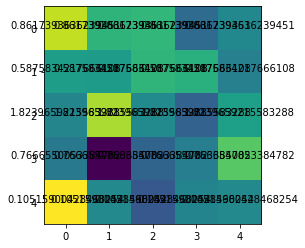

In [106]:
a = np.random.randn(5,5)
b = np.random.randn(5,5)
plt.imshow(b,interpolation='nearest')
for i, j in itertools.product(range(5), range(5)):
    plt.text(i,j,a[j][j],horizontalalignment="center")
plt.show()

# 3. Implement a Neural Network - Multiclass Classification 
In the previous step, I discussed about how to implement a NN for binary classification in python from scratch. Python's libraries such as sklearn provides an excellent implementation of efficient neural networks which can be used to directly implement neural networks on a dataset. In this section, lets implement a multi class neural network to classify the digit shown in an image from 0 to 9

## 3.1 Dataset Preparation
Slice the train dataset into train and validation set

In [95]:
Y = train['label'][:20000] # use more number of rows for more training 
X = train.drop(['label'], axis = 1)[:20000] # use more number of rows for more training 
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.20, random_state=42)

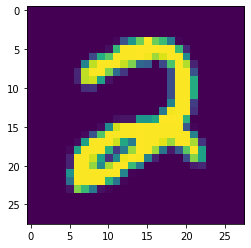

In [96]:
# Some examples
plt.imshow(x_train.iloc[0].values.reshape(28,28))

## 3.2 Train the Model
Train a neural network model with 10 hidden layers.

In [97]:
from sklearn import neural_network
model = neural_network.MLPClassifier(alpha=1e-5, hidden_layer_sizes=(80,), solver='lbfgs', random_state=18)
model.fit(x_train, y_train)

d:\python机器学习\其他\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(alpha=1e-05, hidden_layer_sizes=(80,), random_state=18,
              solver='lbfgs')

## 3.3 Predictions

In [98]:
predicted = model.predict(x_val)
print("Classification Report:\n %s:" % (metrics.classification_report(y_val, predicted)))
print(model.score(x_val,y_val))

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       390
           1       0.98      0.98      0.98       483
           2       0.90      0.91      0.91       386
           3       0.93      0.91      0.92       412
           4       0.92      0.92      0.92       379
           5       0.92      0.90      0.91       355
           6       0.93      0.95      0.94       396
           7       0.93      0.92      0.93       452
           8       0.90      0.91      0.91       356
           9       0.90      0.90      0.90       391

    accuracy                           0.93      4000
   macro avg       0.93      0.93      0.93      4000
weighted avg       0.93      0.93      0.93      4000
:
0.92975


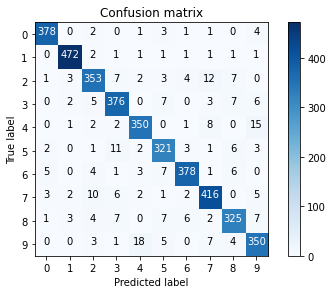

In [99]:
confusion_mtx = confusion_matrix(predicted, y_val) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

In [110]:
# Display some error results 
def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow(img_errors.iloc[error].values.reshape(28,28)) 
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors.values[error]))
            n += 1
    fig.tight_layout()


In [131]:
# Errors are difference between predicted labels and true labels
errors = (predicted - y_val != 0)
pred_classes_errors = predicted[errors]#预测后的值（预测错误的部分）
image_errors = x_val[errors]#对应的像素
true_classes_errors = y_val[errors]#真实的值
error_idx = np.random.randint(low=0, high=len(image_errors), size=6)#取六个随机数

In [129]:
print(error_idx)

[225 186 253 209 111  79]


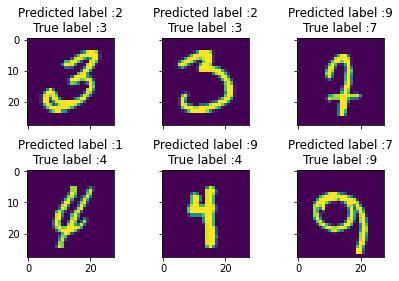

In [112]:
# Show the 6 errors
display_errors(error_idx,image_errors ,pred_classes_errors, true_classes_errors)